<a href="https://colab.research.google.com/github/ElektrosStulpas/QuantumRNN-BachelorsVU/blob/main/QRNNimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install needed libraries

In [1]:
!pip install qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━

Data preparation

In [2]:
from google.colab import drive
import pandas as pd
import os
import numpy as np

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SPY_5YEAR_DAILY = 'duomenys_yahoo_SPY_20220424.csv'
root_path = "/content/drive/MyDrive/QRNNData"

def load_stock_data_from_drive(root_path, data_file_name):
  data = pd.read_csv(os.path.join(root_path, SPY_5YEAR_DAILY))
  return data

def save_params_to_drive(root_path, file_name, params):
  np.save(os.path.join(root_path, file_name), params)

def load_params_from_drive(root_path, file_name):
  return np.load(os.path.join(root_path, file_name))

In [5]:
#currently data passed in as series and passed out as series
def rescale_data(data, new_scale_from, new_scale_to, maxmin):
  #NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
  rescaled_x = (new_scale_to-new_scale_from) * ((data - maxmin[1]) / ( maxmin[0] - maxmin[1])) + new_scale_from

  return rescaled_x

In [6]:
spy_data = load_stock_data_from_drive(root_path, SPY_5YEAR_DAILY)
close_data = spy_data["Close"]

data_maxmin = max(close_data), min(close_data)

labels = close_data.shift(-1)
inputs = rescale_data(close_data, -1, 1, data_maxmin)

TRAIN_len = 300 - 300%7
inputs_TRAIN = np.array(inputs[:TRAIN_len]).reshape(-1, 7)
labels_TRAIN = np.array(labels[:TRAIN_len]).reshape(-1, 7)
training_data = list(zip(inputs_TRAIN, labels_TRAIN))

VALID_len = (200 - 200%7) + 300
inputs_VALID = np.array(inputs[300:VALID_len]).reshape(-1, 7)
labels_VALID = np.array(labels[300:VALID_len]).reshape(-1, 7)
validation_data = list(zip(inputs_VALID, labels_VALID))

In [7]:
for input, label in training_data:
  print(f"{input} {label}")

[-0.88836551 -0.87753174 -0.87870939 -0.87713919 -0.8812215  -0.87651125
 -0.87580462] [238.550003 238.399994 238.600006 238.080002 238.679993 238.770004
 238.479996]
[-0.87808134 -0.8758832  -0.86850369 -0.86881765 -0.87054478 -0.86716911
 -0.87101579] [238.759995 239.699997 239.660004 239.440002 239.869995 239.380005
 238.979996]
[-0.87415607 -0.86379332 -0.86552045 -0.89896365 -0.89150567 -0.87941591
 -0.86991673] [240.300003 240.080002 235.820007 236.770004 238.309998 239.520004
 240.050003]
[-0.86575596 -0.86135968 -0.85233162 -0.85272405 -0.85437272 -0.85484373
 -0.83977073] [240.610001 241.759995 241.710007 241.5      241.440002 243.360001
 244.169998]
[-0.83341183 -0.83482487 -0.84094826 -0.83741555 -0.83647352 -0.83937818
 -0.83977073] [243.990005 243.210007 243.660004 243.779999 243.410004 243.360001
 244.550003]
[-0.83042859 -0.83286224 -0.83655199 -0.84542312 -0.82956502 -0.84251846
 -0.84298948] [244.240005 243.770004 242.639999 244.660004 243.009995 242.949997
 242.839996

In [8]:
print(f"labels_TRAIN len: {len(labels_TRAIN)}, input_TRAIN len: {len(inputs_TRAIN)}, labels_VALID len: {len(labels_VALID)}, input_VALID len: {len(inputs_VALID)}")

labels_TRAIN len: 42, input_TRAIN len: 42, labels_VALID len: 28, input_VALID len: 28


Model

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

import numpy as np

In [10]:
#takes input vector of value from -1 to 1, outputs predictions vector in the same value range
class QRNN:
  def __init__(self, q_reg=3, params=None):
    self.QRNN_circuit = QuantumCircuit(q_reg*2)
    self.qubits_per_reg = q_reg

    if params is not None:
      self.params = params
    else:
       self.params = self.init_random_params()

    self.ansatz = self.construct_ansatz()


  def set_params(self, params):
    self.params = params
    self.ansatz = self.construct_ansatz()

  def get_params(self):
    return self.params


  def forward(self, x_vec):
    prediction_vec = []

    self.QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    for idx in range(7):
      self.QRNN_circuit.reset(list(range(self.qubits_per_reg)))
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      self.QRNN_circuit.compose(encoding_circ, list(range(self.qubits_per_reg)), inplace=True)

      self.QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

      y_t = self.partial_trace_measure(self.QRNN_circuit)
      # prediction_vec.append(abs(y_t)*2-1) # getting the magnitude of complex number and rescaling from 0:1 to -1:1
      prediction_vec.append(abs(y_t))

    return np.array(prediction_vec)


  def backward():
    print("backward pass")


  def construct_enc_circ(self, x_val):
    enc_circ = QuantumCircuit(self.qubits_per_reg)

    for qubit in range(self.qubits_per_reg):
      enc_circ.ry(np.arccos(x_val), qubit)

    return enc_circ


  def construct_ansatz(self):
    theta_gamma_params = self.params

    ansatz = QuantumCircuit(self.qubits_per_reg*2)

    qu_indexes = list(range(self.qubits_per_reg*2))
    qu_indexes_rolled = list(range(1, self.qubits_per_reg*2))
    qu_indexes_rolled.append(0)

    for idx in qu_indexes:
      ansatz.rx(theta_gamma_params[idx][0], idx)
      ansatz.rz(theta_gamma_params[idx][1], idx)
      ansatz.rx(theta_gamma_params[idx][2], idx)

    for idx in qu_indexes:
      ansatz.cnot(idx, qu_indexes_rolled[idx])
      ansatz.rz(theta_gamma_params[idx][3], qu_indexes_rolled[idx])
      ansatz.cnot(idx, qu_indexes_rolled[idx])

    return ansatz


  def partial_trace_measure(self, circuit):
    circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
    qubits_to_trace_out = list(range(self.qubits_per_reg*2))[1:]

    measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

    ket1 = qi.Statevector([0, 1])
    projector1 = ket1.to_operator()

    trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
    prediction_y = trimmed_measured_qubit_rho.trace()

    return prediction_y


  def init_random_params(self):
    rng = np.random.default_rng()
    theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(self.qubits_per_reg*2, 4))) #6x3 theta params and 6x1 gamma params
    return theta_gamma_params

In [11]:
# generating random params and saving it to be reused so it would be easier to measure performance with different parameters

# model = QRNN()
# save_params_to_drive(root_path, "6_qubit_params", model.get_params())

In [12]:
qubit_num = 6
rng = np.random.default_rng()
theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(qubit_num, 4)))

print(theta_gamma_params)

qu_indexes = list(range(qubit_num))
qu_indexes_rolled = list(range(1, qubit_num))
qu_indexes_rolled.append(0)

for idx in qu_indexes:
  print(f"RX: {theta_gamma_params[idx][0]}, RZ: {theta_gamma_params[idx][1]}, RX: {theta_gamma_params[idx][2]} for qubit {idx}")

for idx in qu_indexes:
  print(f"RZ: {theta_gamma_params[idx][3]} gamma on qubit {qu_indexes_rolled[idx]}")

[[1.46178391 1.34855866 1.13923689 0.44375906]
 [1.85767993 1.58763063 2.32048178 1.1580764 ]
 [1.41006768 0.26975357 1.28381771 2.96794529]
 [2.45760262 1.17456292 0.97811042 1.93780695]
 [2.86980408 2.46919869 1.52151217 1.05737842]
 [1.41466471 2.08915146 2.43868034 1.39773397]]
RX: 1.4617839131264203, RZ: 1.3485586560759706, RX: 1.139236885366038 for qubit 0
RX: 1.857679926437659, RZ: 1.5876306294991533, RX: 2.320481782121376 for qubit 1
RX: 1.4100676807256707, RZ: 0.2697535703639411, RX: 1.2838177104093655 for qubit 2
RX: 2.45760261773721, RZ: 1.1745629198821046, RX: 0.9781104215932742 for qubit 3
RX: 2.869804081078653, RZ: 2.469198692658937, RX: 1.521512165817042 for qubit 4
RX: 1.4146647096410883, RZ: 2.0891514597810263, RX: 2.4386803374335053 for qubit 5
RZ: 0.4437590604730604 gamma on qubit 1
RZ: 1.158076398434982 gamma on qubit 2
RZ: 2.967945286802566 gamma on qubit 3
RZ: 1.937806954248559 gamma on qubit 4
RZ: 1.0573784183169093 gamma on qubit 5
RZ: 1.397733974151892 gamma on

TRAINING

In [13]:
import random

In [14]:
def L2_loss(predictions_vec, true_vec):
  loss = np.mean((predictions_vec-true_vec)**2)
  return loss

# arr1 = np.array([2, 5, 7])
# arr2 = np.array([-1, 3, 6])

# L2_loss(arr2, arr1)

In [15]:
def postprocess_output(output, x_max, x_min):
  return output * (x_max-x_min) + x_min

In [16]:
def gradient_descent(params, input, labels, maxmin, perturbation=0.001, lr=0.03):
  params_1d = np.reshape(params, -1)
  len_params = len(params_1d)
  gradients = np.zeros(len_params)

  #for every parameter
  for idx in range(len_params):
    #generate index vector
    e_vec = np.zeros(len_params)
    e_vec[idx] = 1

    #generate params with finite diff to both sides
    params_1d_plus = params_1d + perturbation*e_vec
    params_plus = np.reshape(params_1d_plus, (6, 4)) # that 6 is hard coded
    params_1d_minus = params_1d - perturbation*e_vec
    params_minus = np.reshape(params_1d_minus, (6, 4)) # that 6 is hard coded

    #create QRNNs with the finite difference params
    QRNN_plus = QRNN(params=params_plus)
    QRNN_minus = QRNN(params=params_minus)

    # run forward pass to get predictions 
    predictions_plus = postprocess_output(QRNN_plus.forward(input), maxmin[0], maxmin[1])
    predictions_minus = postprocess_output(QRNN_minus.forward(input), maxmin[0], maxmin[1])

    #calculate gradient for this parameter
    gradients[idx] = (L2_loss(predictions_plus, labels)-L2_loss(predictions_minus, labels)) / (2*perturbation)

  # print(f"Params 1 dim: \n{params_1d}")
  # print(f"Gradients \n{gradients}")
  # print(f"Gradients with lr: \n{gradients*lr}")

  #apply gradients to parameters and return the updated parameters
  params_1d = params_1d - gradients*lr

  # print(f"Params 1 dim after applying gradients: \n{params_1d}")
  # print(f"Params reshaped: \n{np.reshape(params_1d, params.shape)}")

  return np.reshape(params_1d, params.shape)


In [17]:
def prediction_accuracy(actual, predicted):
  E_vec = (actual-predicted) / actual

  # Alternative accuracy formula
  # accuracy = (1 - np.mean(abs(E_vec))) * 100

  #This accuracy formula is presented in the work
  accuracy = (1-np.mean(E_vec**2)**0.5) * 100
  return accuracy

In [18]:
def after_epoch_validation(model, validation_data, maxmin):

  random.shuffle(validation_data)
  losses = []
  all_accuracy = []

  for input_sequence, label_sequence in validation_data:
    predictions = postprocess_output(model.forward(input_sequence), maxmin[0], maxmin[1])

    loss = L2_loss(predictions, label_sequence)
    losses.append(loss)

    accuracy = prediction_accuracy(label_sequence, predictions)
    all_accuracy.append(accuracy)

  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(all_accuracy)

  print(f"Validation loss: {avg_loss:.2f}, validation accuracy: {avg_accuracy:.2f}")

In [19]:
def training(model, training_data, maxmin, epochs_num):

  for epoch in range(epochs_num):
    # random.shuffle(training_data)
    losses = []
    all_accuracy = []

    for input_sequence, label_sequence in training_data:
      predictions = model.forward(input_sequence)
      predictions = postprocess_output(predictions, maxmin[0], maxmin[1])

      loss = L2_loss(predictions, label_sequence)
      losses.append(loss)

      accuracy = prediction_accuracy(label_sequence, predictions)
      all_accuracy.append(accuracy)

      updated_params = gradient_descent(model.get_params(), input_sequence, label_sequence, maxmin)
      model.set_params(updated_params)

      if len(losses)%5 == 0:
        print(f"Average running loss: {np.mean(losses):.2f} Average running accuracy: {np.mean(all_accuracy):.2f}")
        print(f"Current sentence predictions were: \n{predictions} \nAnd labels were: \n{label_sequence}")
        print("=====================================")

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(all_accuracy)
    print(f"\nEpoch {epoch+1} / {epochs_num}: Loss = {avg_loss:.2f}, Accuracy: {avg_accuracy:.2f}\n")

    # after_epoch_validation(model, validation_data, maxmin)

  return model



SANITY CHECKS FOR GRADIENT DESCENT

In [20]:
model = QRNN()

In [21]:

input_sequence, label_sequence = training_data[0]

predictions = postprocess_output(model.forward(input_sequence), data_maxmin[0], data_maxmin[1])
print(f"Current sentence predictions were: \n{predictions} \nAnd labels were: \n{label_sequence}")

Current sentence predictions were: 
[297.21672942 297.19048471 297.19193492 297.19007403 297.19613947
 297.18949208 297.18894681] 
And labels were: 
[238.550003 238.399994 238.600006 238.080002 238.679993 238.770004
 238.479996]


In [22]:
params_before = model.get_params()
print(params_before)

[[0.83974393 2.59630831 2.73808518 1.88914171]
 [2.89814099 0.54750749 2.47750836 2.00098461]
 [1.31511717 1.7784872  1.84174151 1.93088337]
 [2.47588098 1.6161323  2.50843908 1.36261607]
 [0.3390196  1.62364614 1.14639313 1.54625658]
 [1.5535238  1.89820673 1.5280693  1.3077005 ]]


In [23]:
updated_params = gradient_descent(model.get_params(), input_sequence, label_sequence, data_maxmin, 0.001)
model.set_params(updated_params)

In [24]:
print(model.get_params())
print(updated_params)

[[-3.57598808e+02 -1.28894373e+02  2.35137527e+02  1.88914171e+00]
 [ 2.89814099e+00  5.47507492e-01  2.47750836e+00  2.00098461e+00]
 [ 1.31511717e+00  1.77848720e+00  1.84174151e+00  1.93088337e+00]
 [ 2.47588098e+00  1.61613230e+00  2.50843908e+00  1.36261607e+00]
 [ 3.39019601e-01  1.62364614e+00  1.14639313e+00  1.54625658e+00]
 [ 1.55352380e+00  1.89820673e+00  1.52806930e+00  1.30770050e+00]]
[[-3.57598808e+02 -1.28894373e+02  2.35137527e+02  1.88914171e+00]
 [ 2.89814099e+00  5.47507492e-01  2.47750836e+00  2.00098461e+00]
 [ 1.31511717e+00  1.77848720e+00  1.84174151e+00  1.93088337e+00]
 [ 2.47588098e+00  1.61613230e+00  2.50843908e+00  1.36261607e+00]
 [ 3.39019601e-01  1.62364614e+00  1.14639313e+00  1.54625658e+00]
 [ 1.55352380e+00  1.89820673e+00  1.52806930e+00  1.30770050e+00]]


In [25]:
input_sequence, label_sequence = training_data[0]

predictions = postprocess_output(model.forward(input_sequence), data_maxmin[0], data_maxmin[1])
print(f"Current sentence predictions were: \n{predictions} \nAnd labels were: \n{label_sequence}")

Current sentence predictions were: 
[289.03873799 289.64974685 289.58304512 289.67199548 289.44098515
 289.70760055 289.74768985] 
And labels were: 
[238.550003 238.399994 238.600006 238.080002 238.679993 238.770004
 238.479996]


TRAINING the model

In [26]:
loaded_params = load_params_from_drive(root_path, "6_qubit_params.npy")

In [27]:
loaded_params

array([[1.71844876, 2.04838708, 1.65311667, 0.46461651],
       [1.12144523, 1.17159783, 1.71884063, 1.26738357],
       [0.91594512, 1.86570833, 1.94842573, 0.57828036],
       [1.17263427, 2.53478912, 1.10382683, 1.90555317],
       [1.43265092, 0.9580048 , 1.75344986, 1.34060377],
       [0.98705363, 0.61479902, 1.85558472, 0.53640413]])

In [ ]:
loaded_params = load_params_from_drive(root_path, "6_qubit_params.npy")

trained_model = training(QRNN(params=loaded_params), training_data, data_maxmin, 2)

save_params_to_drive(root_path, "001pert_03lr_grad_minus_no_shuffle", trained_model.get_params())

Could try normalizing params to 0-pi range, since now they seem to be way over the 0-3.14 rad radius after gradients are applied

print out average predictions and average labels to see if they're converging at all

VALIDATION (inference)

In [ ]:
def inference(model, seven_day_vec, maxmin):
  print(f"Seven day data: {seven_day_vec}")

  predictions = postprocess_output(model.forward(seven_day_vec), maxmin[0], maxmin[1])
  
  print(f"Prediction for the eight day: {predictions[-1]}")

  return predictions[-1]

In [ ]:
params_1d = np.reshape(theta_gamma_params, -1)
e_vec = np.zeros(len(params_1d))
e_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
theta_gamma_params

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
np.reshape(params_1d, (6, 4))

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
params = np.array([[1, 2, 3],[4, 5, 6]])

gradient_descent(params, 0)

[[1 2 3]
 [4 5 6]]
[1.001 2.    3.    4.    5.    6.   ]
[0.999 2.    3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.001 3.    4.    5.    6.   ]
[1.    1.999 3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.001 4.    5.    6.   ]
[1.    2.    2.999 4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.001 5.    6.   ]
[1.    2.    3.    3.999 5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.001 6.   ]
[1.    2.    3.    4.    4.999 6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.    6.001]
[1.    2.    3.    4.    5.    5.999]
[1 2 3 4 5 6]


In [ ]:
QRNN_model = QRNN()
qc, model = QRNN_model.forward(inputs)

In [ ]:
qc

array([-0.25984296, -0.19762551, -0.23026206, -0.02800841, -0.12198073,
        0.2522841 ,  0.10216996])

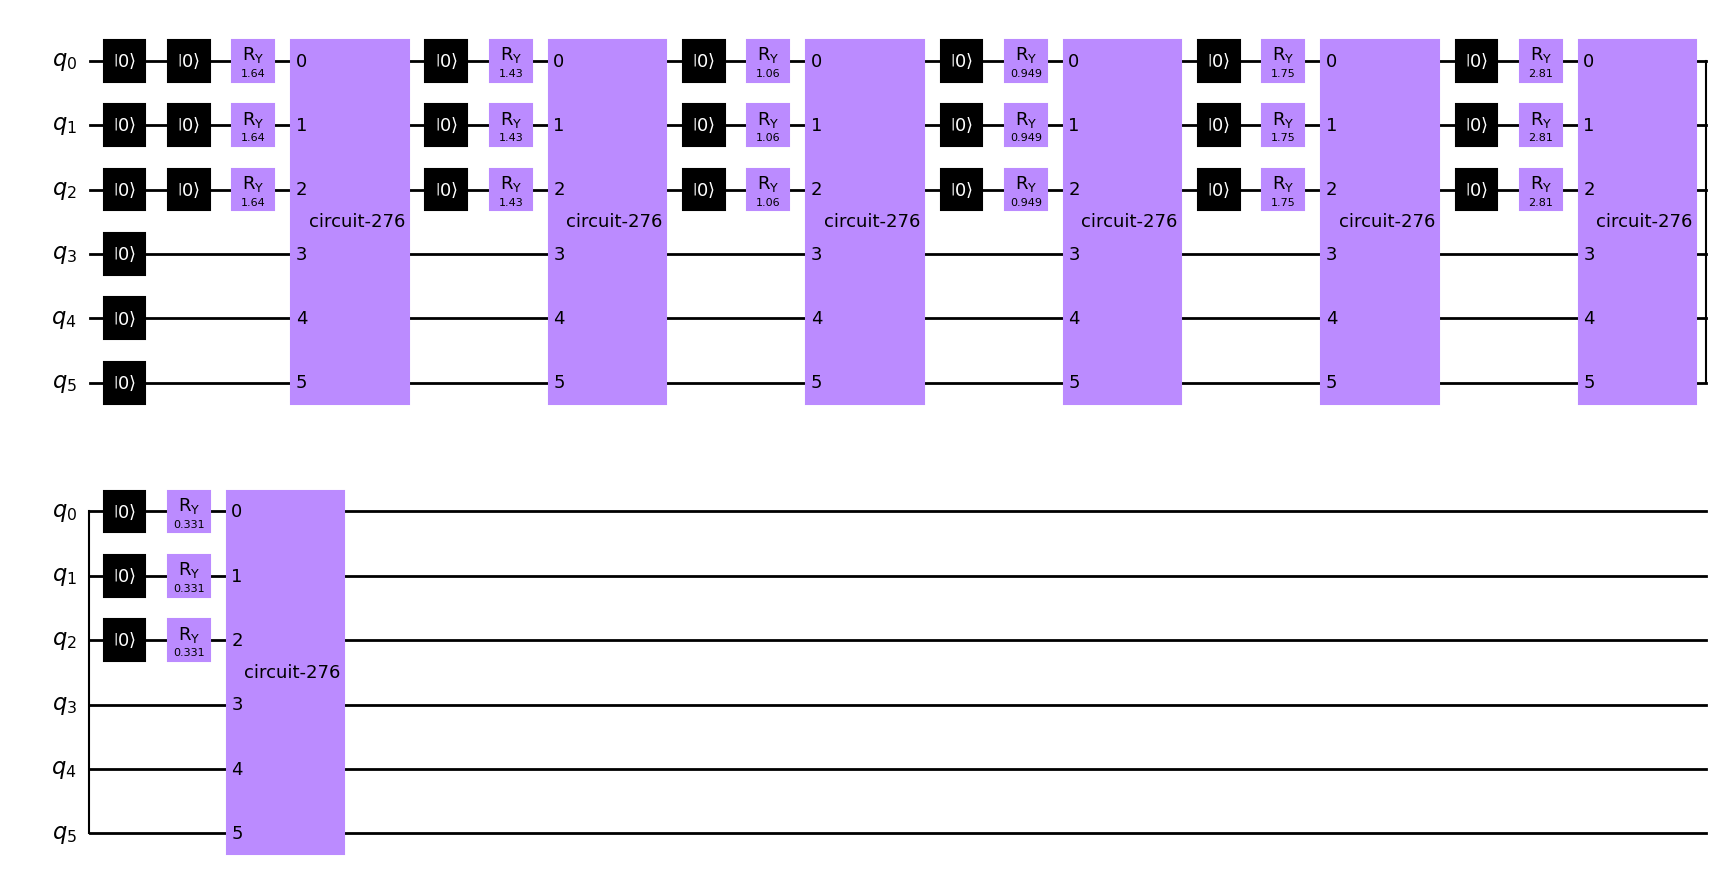

In [ ]:
model.draw("mpl")

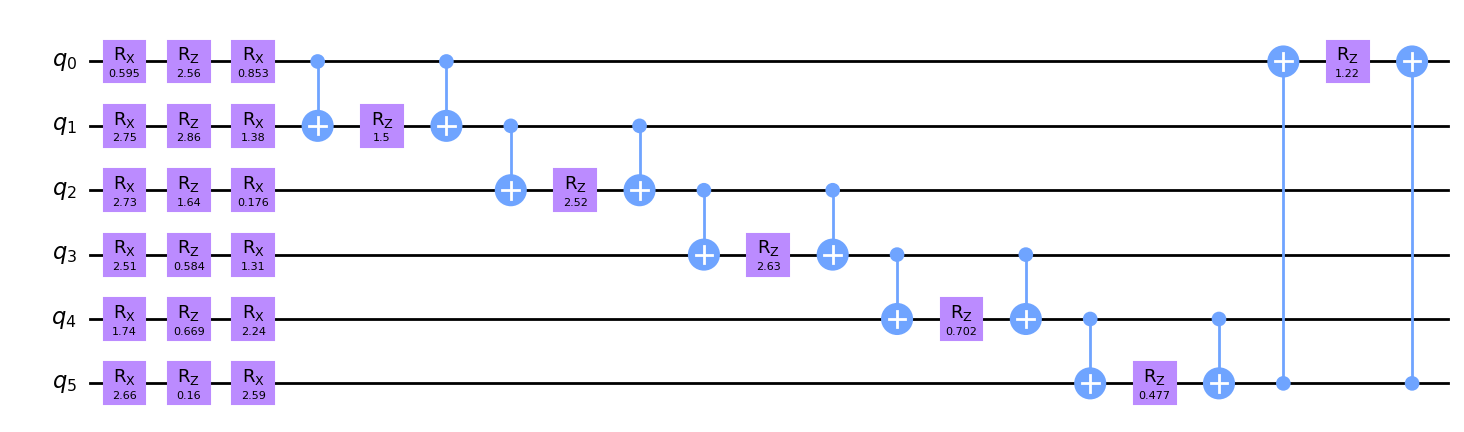

In [ ]:
ans = QRNN_model.construct_ansatz()
ans.draw("mpl")

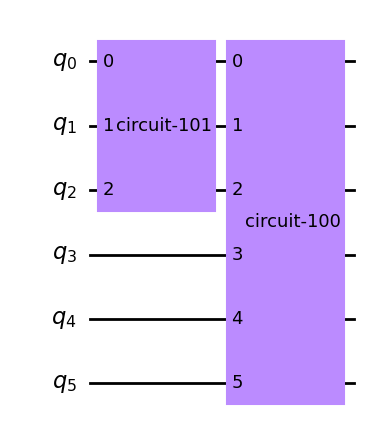

In [ ]:
qc.draw('mpl')

In [ ]:
import numpy as np

# x = 128.54
x = np.array([1, 3, 4, 5, -1, -7])
# goal : range [0, 1]
#NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
x1 = ((x - min(x)) / ( max(x) - min(x)))*2-1
print(x1)
# math.acos(x)
# print(math.acos(x))

# print(math.acos(0.55))


[ 0.33333333  0.66666667  0.83333333  1.          0.         -1.        ]


In [ ]:
rng = np.random.default_rng()
weights = rng.uniform(-1, 1, size=(6, 3))

In [ ]:
weights[]

array([[-0.68669286, -0.59068147, -0.94100421],
       [-0.52644754,  0.58167242, -0.14022919],
       [ 0.19528282,  0.08767172, -0.97406722],
       [-0.29248123,  0.09339544,  0.51187105],
       [-0.70119153,  0.19938807,  0.96372905],
       [-0.93182738,  0.55379874,  0.73056861]])

In [ ]:
weights[0][0]

-0.6866928594082833

In [ ]:
gamma_params = np.arccos(rng.uniform(-1, 1, size=(6, 1)))

In [ ]:
gamma_params

array([[2.01756771],
       [2.00816587],
       [2.63754127],
       [1.96501209],
       [2.97102456],
       [2.59263829]])

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


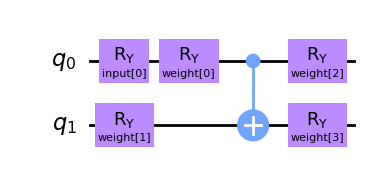

In [ ]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
# qc2.ry(inputs2[1], 1)
# qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

In [ ]:
for idx in list(range(6)):
  print(idx, )

0
1
2
3
4
5


In [ ]:
range_list = list(range(1, 6))

In [ ]:
range_list.append(0)

In [ ]:
new_list = range_list.append(range_list.pop(0))

In [ ]:
range_list

[1, 2, 3, 4, 5, 0]

In [ ]:
new_list

In [ ]:
for idx in range_list:
  print(f"Regular id: {idx}, rolled idx: {range_list[idx]}")

Regular id: 0, rolled idx: 0
Regular id: 1, rolled idx: 1
Regular id: 2, rolled idx: 2
Regular id: 3, rolled idx: 3
Regular id: 4, rolled idx: 4
Regular id: 5, rolled idx: 5


In [ ]:
list(range(3*2))[1:]

[1, 2, 3, 4, 5]

In [ ]:
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
circuit.h(1)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.ch(1, 0)

circuit.draw()

┌───┐
q_0: ─────┤ H ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
c: 2/══════════

In [ ]:
y_t = QRNN_model.partial_trace_measure(circuit)

In [ ]:
# importing "cmath" for complex number operations
import cmath
 
# Initializing real numbers
x = 5
y = 3
 
# converting x and y into complex number
z = complex(x,y);

In [ ]:
z

(5+3j)

In [ ]:
abs(z)

5.830951894845301

In [27]:
drive.flush_and_unmount() #save to drive when finishing work